# ¿Cuál es un mejor plan?

Como analista de Megaline, he realizado un análisis preliminar de nuestras tarifas de prepago, Surf y Ultimate, basado en una muestra de 500 clientes seleccionados y su comportamiento a lo largo del año 2018. El objetivo de este análisis es determinar cuál de las tarifas genera más ingresos y brindarles una visión general del comportamiento de los clientes.

Espero que este análisis les sea útil para tomar decisiones informadas sobre las estrategias de Megaline.

**Descripción de las tarifas**
Nota: Megaline redondea los segundos a minutos y los megabytes a gigabytes. Para llamadas, cada llamada individual se redondea: incluso si la llamada duró solo un segundo, se contará como un minuto. Para tráfico web, las sesiones web individuales no se redondean. En vez de esto, el total del mes se redondea hacia arriba. Si alguien usa 1025 megabytes este mes, se le cobrarán 2 gigabytes.

**Surf**

1. Pago mensual: 20usd
2. 500 minutos al mes, 50 SMS y 15 GB de datos
3. Si se exceden los límites del paquete:
4. 1 minuto: 3 centavos
5. 1 SMS: 3 centavos
6. 1 GB de datos: 10usd

**Ultimate**

1. Pago mensual: 70usd
2. 3000 minutos al mes, 1000 SMS y 30 GB de datos
3. Si se exceden los límites del paquete:
4. 1 minuto: 1 centavo
5. 1 SMS: 1 centavo
6. 1 GB de datos: 7usd

## Inicialización

In [1]:
# Cargamos todas las librerías
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats as st
from math import factorial

## Cargar los datos

In [2]:
# Cargamos los archivos de datos en diferentes DataFrames
calls_df = pd.read_csv('/datasets/megaline_calls.csv')
internet_df = pd.read_csv('/datasets/megaline_internet.csv')
messages_df = pd.read_csv('/datasets/megaline_messages.csv')
plans_df = pd.read_csv('/datasets/megaline_plans.csv')
users_df = pd.read_csv('/datasets/megaline_users.csv')

## Preparar los datos

Los datos para este proyecto se dividen en muchas tablas. Exploraremos cada una para tener una comprensión inicial de los datos. Si es necesario, haremos las correcciones necesarias a cada tabla.

## Planes

In [3]:
# Imprimos la información general/resumen sobre el DataFrame de los planes
plans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [4]:
# Imprimimos una muestra de los datos para los planes
plans_df.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


A simple vista no se ve **ningún problema** en los datos, no se ven datos nulos en las columnas y el tipo de datos de cada columna corresponden con los datos esperados.

## Enriquecer los datos

Lo que probabalemente nos podría ayudar a enriquecer los datos de este Dataframe y ahorraros problemas futuros sería cambiar el tipo de datos de la columna **'usd_monthly_pay'** ya que si algún usuario excede su plan, **podrían cargarle centavos** a su pago mensual.

In [5]:
# Cambiamos los valores a tipo float
plans_df['usd_monthly_pay'] = plans_df['usd_monthly_pay'].astype(float)

## Usuarios

In [6]:
# Imprimimos la información general/resumen sobre el DataFrame de los usuarios
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [7]:
# Imprimimos una muestra de los datos para los usuarios
users_df.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


1. En este Dataframe (users) podemos ver que **tenemos valores nulos** en la columna 'churn_date', sin embargo, como la columna hace referencia a la fecha de abandono del servicio, concluimos que son **clientes activos**. Los 34 restantes, han abandonado el servicio.
2. En la columna **reg_date** tenemos datos tipo object y preferimos utilizar tipo **datetime** para facilitar su trato.
3. En la columna **'plan'** tenemos valores tipo object y preferimos cambiarlos a tipo **categoria**.

### Corregir datos

Vamos a corregir los tipos de datos que tenemos en nuestras columnas

In [8]:
# Tipos de datos de fechas
users_df['reg_date'] = pd.to_datetime(users_df['reg_date'])

In [9]:
# Tipos de datos de categoria
users_df['plan'] = users_df['plan'].astype('category')

### Enriquecer datos

Ahora vamos a facilitar el uso de los datos, cambiemos los valores nulos y asignarles la referencia de **'plan activo'** en la columna 'churn_date'.

In [10]:
users_df['churn_date'].fillna('active plan', inplace=True)

In [11]:
# Veamos otra vez la apariencia de nuestro Dataframe con los cambios
users_df.info()
users_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    category      
 7   churn_date  500 non-null    object        
dtypes: category(1), datetime64[ns](1), int64(2), object(4)
memory usage: 28.1+ KB


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,active plan
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,active plan
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,active plan
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,active plan
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,active plan


Ahora vamos a agregar una columna donde venga el estado de cada usuario. Esto nos ayudara a porbar una hipotesis posteriormente

In [12]:
# Mostramos solamente el estado en la columna 'state'
users_df['state'] = users_df['city'].str[-6:].str[:2]

In [13]:
# Quitemos la fila 'city' ya que, solo nos interesa el estado de cada usuario
users_df = users_df.drop('city', axis=1)

In [14]:
# Veamos como se ve nuestro Dataframe
users_df.head()

,user_id,first_name,last_name,age,reg_date,plan,churn_date,state
0,1000,Anamaria,Bauer,45,2018-12-24,ultimate,active plan,GA
1,1001,Mickey,Wilkerson,28,2018-08-13,surf,active plan,WA
2,1002,Carlee,Hoffman,36,2018-10-21,surf,active plan,NV
3,1003,Reynaldo,Jenkins,52,2018-01-28,surf,active plan,OK
4,1004,Leonila,Thompson,40,2018-05-23,surf,active plan,WA


Teniendo este Dataframe más limpio, podemos seguir analizando los siguientes.

## Llamadas

In [15]:
# Imprimimos la información/resumen general sobre el DataFrame de las llamadas
calls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [16]:
# Imprimimos una muestra de datos para llamadas
calls_df.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


Podemos ver que tenemos la misma situación de fechas en la columna **'call_date'**, de ahí en más el Dataframe parece tener buena calidad de datos.

Verifiquemos valores de las columnas de este Dataframe, esperando que cumplan con su formato, tamaño, etc.

In [17]:
calls_df['id'].tail()

137730    1499_199
137731    1499_200
137732    1499_201
137733    1499_202
137734    1499_203
Name: id, dtype: object

In [18]:
# Busquemos duplicados de id
calls_df['id'].duplicated().any()

False

In [19]:
# Veamos si alguna llamada tiene duración negativa
(calls_df['duration'] <= 0).any()

True

Podemos ver que si tenemos valores con duración de llamada 0 o menos, veamos cuales son para poder abordarlos de la mejor manera.

In [20]:
neg_calls = calls_df.query('duration <= 0')
neg_calls

,id,user_id,call_date,duration
19,1001_4,1001,2018-12-05,0.0
25,1001_13,1001,2018-12-24,0.0
31,1001_30,1001,2018-10-17,0.0
32,1001_31,1001,2018-11-03,0.0
34,1001_35,1001,2018-12-21,0.0
...,...,...,...,...
137714,1499_183,1499,2018-11-10,0.0
137715,1499_184,1499,2018-09-15,0.0
137720,1499_189,1499,2018-12-27,0.0
137722,1499_191,1499,2018-12-24,0.0


Como sabemos que el cobro de llamadas y su redondeo es a partir de 1 segundo, decidimos dejar esos valores (0) como válidos por ahora, ya que podemos sacar conclusiones en un futuro.

### Corregir datos

Cambiemos el tipo de datos de la columna **'call_date' a datetime**

In [21]:
calls_df['call_date'] = pd.to_datetime(calls_df['call_date'])

### Enriquecer datos

Vamos a agregar factores adicionales a los datos para facilitar su trato.

- Redondearemos la duración de las llamadas a minutos y las convertiremos en tipo int.
- Crearemos una columna 'month' para un análisis más detallado

In [22]:
# Vamos a redondear la duración de las llamadas a minutos y tipo int
calls_df['duration'] = np.ceil(calls_df['duration']).astype(int)

In [23]:
# Creamos la columna 'month'
calls_df['month'] = calls_df['call_date'].dt.month

Ahora sumemos el total de duración de llamadas ya redondeadas de cada usuario / mes, esto nos facilitará los calculos y su trato durante el análisis.

In [24]:
# Agrupamos para obtener el total de llamadas y su duración total
calls_monthly_total = calls_df.groupby(['user_id', 'month']).agg({'id': 'count', 'duration': 'sum'})

In [25]:
# Renombramos las columnas
calls_monthly_total.rename(columns={'id': 'total_calls', 'duration': 'total_duration'}, inplace=True)

In [26]:
calls_monthly_total = calls_monthly_total.reset_index()

In [27]:
calls_monthly_total.head()

,user_id,month,total_calls,total_duration
0,1000,12,16,124
1,1001,8,27,182
2,1001,9,49,315
3,1001,10,65,393
4,1001,11,64,426


## Mensajes

In [28]:
# Imprimimos la información/resumen general sobre el DataFrame de los mensajes
messages_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [29]:
# Imprimimos una muestra de datos para los mensajes
messages_df.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


Podemos ver que el número de entradas coincide en las columnas, esto nos indica que **no existen valores nulos.**

También podemos ver que **'message_date'** contiene valores tipo **'objetct'** cuando deben ser datetime

### Corregir datos

Cambiemos los valores de la columna 'message_date'

In [30]:
# Convertimos valores de la columna a tipo datetime
messages_df['message_date'] = pd.to_datetime(messages_df['message_date'])

### Enriquecer datos

Vamos a agregar factores adicionales a los datos para facilitar su trato.

- Crearemos nueva columna para el mes
- Crearemos un dataframe que contenga el total de mensajes por mes por cada usuario

In [31]:
# Creamos nueva columna para el mes
messages_df['month'] = messages_df['message_date'].dt.month

In [32]:
# Agrupamos datos por 'user_id' y 'month'
messages_monthly_total = messages_df.groupby(['user_id', 'month'])['id'].count().reset_index()

In [33]:
messages_monthly_total.rename(columns={'id': 'total_messages'}, inplace=True)

In [34]:
messages_monthly_total.head()

,user_id,month,total_messages
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36


## Internet

In [35]:
# Imprimimos la información/resumen general sobre el DataFrame de los mensajes
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [36]:
# Imprimimos una muestra de datos para el tráfico de internet
internet_df.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


Podemos ver que la columna **'session_date'** tiene valores tipo object, habrá que convertirlos a datetime para facilitar su trato.

**No tenemos valores ausentes**, ya que todas las columnas cuentan con el mismo valor de filas.

Hay que tener en cuenta que **el total del mes se redondea hacia arriba**, esto lo trataremos en el apartado de enriquecer datos.

### Corregir datos

In [37]:
# Convertimos valores de la columna a tipo datetime
internet_df['session_date'] = pd.to_datetime(internet_df['session_date'])

### Enriquecer datos

Tendremos que sacar las cuentas del uso de internet al mes para cada usuario para poder redondear los GB hacia arriba

In [38]:
# Primero creamos una nueva columna 'month'
internet_df['month'] = internet_df['session_date'].dt.month

In [39]:
# Agrupamos datos por 'user_id' y 'month'
internet_monthly_total = internet_df.groupby(['user_id', 'month']).agg({'mb_used': 'sum'}).reset_index()

In [40]:
# Convertimos MB a GB
internet_monthly_total['gb_used'] = internet_monthly_total['mb_used'] / 1024

In [41]:
# Eliminamos la columna mb_used
internet_monthly_total.drop('mb_used', axis=1, inplace=True)

In [42]:
# Redondeamos hacia arriba los valores de GB utilizados y los convertimos a enteros
internet_monthly_total['gb_used'] = internet_monthly_total['gb_used'].apply(np.ceil).astype(int)

In [43]:
internet_monthly_total.head()

,user_id,month,gb_used
0,1000,12,2
1,1001,8,7
2,1001,9,14
3,1001,10,22
4,1001,11,19


## Estudiar las condiciones del plan

Es sumamente importante entender cómo funcionan los planes, cómo se cobra a los usuarios con base en su plan de suscripción. Así que imprimimamos la información del plan para ver una vez más sus condiciones.

In [44]:
# Imprimimos las condiciones del plan y asegúrate de que te resulten claros
plans_df.info()
plans_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      float64
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(3), int64(4), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20.0,10,0.03,0.03,surf
1,1000,30720,3000,70.0,7,0.01,0.01,ultimate


## Agregar datos por usuario

[Ahora que los datos están limpios, agrega los datos por usuario por periodo para poder tener solo un registro por usuario por periodo. Esto facilitará mucho su posterior análisis.]

In [45]:
# Veamos el número de llamadas hechas por cada usuario por mes.
display(calls_monthly_total['total_calls'].head())

0    16
1    27
2    49
3    65
4    64
Name: total_calls, dtype: int64

In [46]:
# Veamos la cantidad de minutos que usó cada usuario por mes.
display(calls_monthly_total['total_duration'].head())

0    124
1    182
2    315
3    393
4    426
Name: total_duration, dtype: int64

In [47]:
# Veamos el número de mensajes enviados por cada usuario por mes.
display(messages_monthly_total['total_messages'].head())

0    11
1    30
2    44
3    53
4    36
Name: total_messages, dtype: int64

In [48]:
# Veamos el volumen del trafico de internet usado por cada usuario por mes.
display(internet_monthly_total['gb_used'].head())

0     2
1     7
2    14
3    22
4    19
Name: gb_used, dtype: int64

Pongamos los datos agregados juntos en un DataFrame para que tengamos un registro en él que represente lo que un único usuario consumió en un mes determinado.

In [49]:
# Unimos los Dataframes de llamadas e internet
calls_internet = pd.merge(calls_monthly_total, internet_monthly_total, on=['user_id', 'month'], how='outer')
calls_internet

,user_id,month,total_calls,total_duration,gb_used
0,1000,12,16.0,124.0,2.0
1,1001,8,27.0,182.0,7.0
2,1001,9,49.0,315.0,14.0
3,1001,10,65.0,393.0,22.0
4,1001,11,64.0,426.0,19.0
...,...,...,...,...,...
2287,1311,6,NaN,NaN,2.0
2288,1349,10,NaN,NaN,13.0
2289,1349,11,NaN,NaN,17.0
2290,1349,12,NaN,NaN,13.0


In [50]:
# Unimos los Dataframes 'calls_internet' y 'messages_monthly_total'
calls_internet_messages = pd.merge(calls_internet, messages_monthly_total, on=['user_id', 'month'], how='outer')
calls_internet_messages

,user_id,month,total_calls,total_duration,gb_used,total_messages
0,1000,12,16.0,124.0,2.0,11.0
1,1001,8,27.0,182.0,7.0,30.0
2,1001,9,49.0,315.0,14.0,44.0
3,1001,10,65.0,393.0,22.0,53.0
4,1001,11,64.0,426.0,19.0,36.0
...,...,...,...,...,...,...
2288,1349,10,NaN,NaN,13.0,76.0
2289,1349,11,NaN,NaN,17.0,72.0
2290,1349,12,NaN,NaN,13.0,61.0
2291,1361,5,NaN,NaN,2.0,2.0


In [51]:
# Unimos los Dataframes 'calls_internet_messages' y 'users_df'
monthly_use = pd.merge(calls_internet_messages, users_df, on=['user_id'], how='left')
monthly_use

,user_id,month,total_calls,total_duration,gb_used,total_messages,first_name,last_name,age,reg_date,plan,churn_date,state
0,1000,12,16.0,124.0,2.0,11.0,Anamaria,Bauer,45,2018-12-24,ultimate,active plan,GA
1,1001,8,27.0,182.0,7.0,30.0,Mickey,Wilkerson,28,2018-08-13,surf,active plan,WA
2,1001,9,49.0,315.0,14.0,44.0,Mickey,Wilkerson,28,2018-08-13,surf,active plan,WA
3,1001,10,65.0,393.0,22.0,53.0,Mickey,Wilkerson,28,2018-08-13,surf,active plan,WA
4,1001,11,64.0,426.0,19.0,36.0,Mickey,Wilkerson,28,2018-08-13,surf,active plan,WA
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1349,10,NaN,NaN,13.0,76.0,Florentina,Diaz,69,2018-10-01,surf,active plan,NH
2289,1349,11,NaN,NaN,17.0,72.0,Florentina,Diaz,69,2018-10-01,surf,active plan,NH
2290,1349,12,NaN,NaN,13.0,61.0,Florentina,Diaz,69,2018-10-01,surf,active plan,NH
2291,1361,5,NaN,NaN,2.0,2.0,Jacelyn,Hoffman,45,2018-04-14,surf,active plan,AL


Ahora si, teniendo los dataframes unidos, podemos seguir con nuestro análisis y agregar las últimas columnas para realizar los cálculos que nos llevarán al objetivo del proyecto.

In [52]:
# Añadimos la información de cada plan a nuestra tabla
monthly_use = monthly_use.merge(plans_df, left_on='plan', right_on='plan_name', how='left')

Como utilizamos las columnas **plan** para unir dos dataframes, tendremos dos columnas con los planes, por lo que tendremos que eliminar una de ellas. El mismo caso que en 'user_id', solamente que aqui tenemos nombres distintos. Esto hace que podamos utilizar drop.

In [53]:
# Eliminamos la segunda columna 'plan'
monthly_use = monthly_use.drop(['plan'], axis=1)

In [54]:
monthly_use.info()
monthly_use

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                2293 non-null   int64         
 1   month                  2293 non-null   int64         
 2   total_calls            2258 non-null   float64       
 3   total_duration         2258 non-null   float64       
 4   gb_used                2277 non-null   float64       
 5   total_messages         1806 non-null   float64       
 6   first_name             2293 non-null   object        
 7   last_name              2293 non-null   object        
 8   age                    2293 non-null   int64         
 9   reg_date               2293 non-null   datetime64[ns]
 10  churn_date             2293 non-null   object        
 11  state                  2293 non-null   object        
 12  messages_included      2293 non-null   int64         
 13  mb_

,user_id,month,total_calls,total_duration,gb_used,total_messages,first_name,last_name,age,reg_date,churn_date,state,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,1000,12,16.0,124.0,2.0,11.0,Anamaria,Bauer,45,2018-12-24,active plan,GA,1000,30720,3000,70.0,7,0.01,0.01,ultimate
1,1001,8,27.0,182.0,7.0,30.0,Mickey,Wilkerson,28,2018-08-13,active plan,WA,50,15360,500,20.0,10,0.03,0.03,surf
2,1001,9,49.0,315.0,14.0,44.0,Mickey,Wilkerson,28,2018-08-13,active plan,WA,50,15360,500,20.0,10,0.03,0.03,surf
3,1001,10,65.0,393.0,22.0,53.0,Mickey,Wilkerson,28,2018-08-13,active plan,WA,50,15360,500,20.0,10,0.03,0.03,surf
4,1001,11,64.0,426.0,19.0,36.0,Mickey,Wilkerson,28,2018-08-13,active plan,WA,50,15360,500,20.0,10,0.03,0.03,surf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1349,10,NaN,NaN,13.0,76.0,Florentina,Diaz,69,2018-10-01,active plan,NH,50,15360,500,20.0,10,0.03,0.03,surf
2289,1349,11,NaN,NaN,17.0,72.0,Florentina,Diaz,69,2018-10-01,active plan,NH,50,15360,500,20.0,10,0.03,0.03,surf
2290,1349,12,NaN,NaN,13.0,61.0,Florentina,Diaz,69,2018-10-01,active plan,NH,50,15360,500,20.0,10,0.03,0.03,surf
2291,1361,5,NaN,NaN,2.0,2.0,Jacelyn,Hoffman,45,2018-04-14,active plan,AL,50,15360,500,20.0,10,0.03,0.03,surf


Como vemos, ahora si tenemos todos los datos necesarios para el análisis en un solo dataframe. También podemos ver valores nulos en las columnas **total_calls y total_duration**. Esto se debe a que los dataframes que hemos fusionado, no tienen el mismo número de indices, por lo que ha creado valores nulos. Los valores nulos deberán tener la misma cantidad en las columnas, debido a esta fusión. De no ser así, tendríamos que analizar la razón de esta afectación.

Veamos y tratemos esos valores nulos para poder continuar con el objetivo del análisis

In [55]:
monthly_use.isnull().count()

user_id                  2293
month                    2293
total_calls              2293
total_duration           2293
gb_used                  2293
total_messages           2293
first_name               2293
last_name                2293
age                      2293
reg_date                 2293
churn_date               2293
state                    2293
messages_included        2293
mb_per_month_included    2293
minutes_included         2293
usd_monthly_pay          2293
usd_per_gb               2293
usd_per_message          2293
usd_per_minute           2293
plan_name                2293
dtype: int64

In [56]:
monthly_use = monthly_use.fillna(0)

In [57]:
# Veamos de nuevo valores nulos
monthly_use.isnull().sum()

user_id                  0
month                    0
total_calls              0
total_duration           0
gb_used                  0
total_messages           0
first_name               0
last_name                0
age                      0
reg_date                 0
churn_date               0
state                    0
messages_included        0
mb_per_month_included    0
minutes_included         0
usd_monthly_pay          0
usd_per_gb               0
usd_per_message          0
usd_per_minute           0
plan_name                0
dtype: int64

Calculemos los **ingresos mensuales de cada usuario** = restar el límite del paquete gratuito del número total de llamadas, SMS y datos; multiplicar el resultado por el valor de tarifa de llamadas; agregar el cargo mensual según la tarifa de llamadas). 

In [58]:
# Calculemos el ingreso mensual para cada usuario
monthly_use['exceeded_cost_calls'] = (monthly_use['total_calls'] - monthly_use['minutes_included']) * monthly_use['usd_per_minute']
monthly_use['exceeded_cost_messages'] = (monthly_use['total_messages'] - monthly_use['messages_included']) * monthly_use['usd_per_message']

In [59]:
monthly_use['exceeded_data_cost'] = (monthly_use['gb_used'] - monthly_use['mb_per_month_included'] / 1024) * monthly_use['usd_per_gb']

In [60]:
# Eliminemos los negativos
monthly_use[['exceeded_cost_calls', 'exceeded_cost_messages', 'exceeded_data_cost']] = monthly_use[['exceeded_cost_calls', 'exceeded_cost_messages', 'exceeded_data_cost']].clip(lower=0)

In [61]:
monthly_use['total_income'] = monthly_use['exceeded_cost_calls'] + monthly_use['exceeded_cost_messages'] + monthly_use['exceeded_data_cost'] + monthly_use['usd_monthly_pay']

In [62]:
monthly_use

,user_id,month,total_calls,total_duration,gb_used,total_messages,first_name,last_name,age,reg_date,...,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,exceeded_cost_calls,exceeded_cost_messages,exceeded_data_cost,total_income
0,1000,12,16.0,124.0,2.0,11.0,Anamaria,Bauer,45,2018-12-24,...,3000,70.0,7,0.01,0.01,ultimate,0.0,0.00,0.0,70.00
1,1001,8,27.0,182.0,7.0,30.0,Mickey,Wilkerson,28,2018-08-13,...,500,20.0,10,0.03,0.03,surf,0.0,0.00,0.0,20.00
2,1001,9,49.0,315.0,14.0,44.0,Mickey,Wilkerson,28,2018-08-13,...,500,20.0,10,0.03,0.03,surf,0.0,0.00,0.0,20.00
3,1001,10,65.0,393.0,22.0,53.0,Mickey,Wilkerson,28,2018-08-13,...,500,20.0,10,0.03,0.03,surf,0.0,0.09,70.0,90.09
4,1001,11,64.0,426.0,19.0,36.0,Mickey,Wilkerson,28,2018-08-13,...,500,20.0,10,0.03,0.03,surf,0.0,0.00,40.0,60.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1349,10,0.0,0.0,13.0,76.0,Florentina,Diaz,69,2018-10-01,...,500,20.0,10,0.03,0.03,surf,0.0,0.78,0.0,20.78
2289,1349,11,0.0,0.0,17.0,72.0,Florentina,Diaz,69,2018-10-01,...,500,20.0,10,0.03,0.03,surf,0.0,0.66,20.0,40.66
2290,1349,12,0.0,0.0,13.0,61.0,Florentina,Diaz,69,2018-10-01,...,500,20.0,10,0.03,0.03,surf,0.0,0.33,0.0,20.33
2291,1361,5,0.0,0.0,2.0,2.0,Jacelyn,Hoffman,45,2018-04-14,...,500,20.0,10,0.03,0.03,surf,0.0,0.00,0.0,20.00


Podemos ver que algunos usuarios no exceden el plan que tienen y por ende, salen **numeros negativos**. Para asegurarnos que no haya valores negativos (solamente en las columnas de plan excedido) convertimos valores negativos en 0

## Estudia el comportamiento del usuario

Calculemos algunas estadísticas descriptivas para los datos agregados y fusionados que nos sean útiles y que muestren un panorama general captado por los datos. Dibujaremos gráficos útiles para facilitar la comprensión. Dado que la tarea principal es comparar los planes y decidir cuál es más rentable, las estadísticas y gráficas debemos calcularlas por plan.

### Llamadas

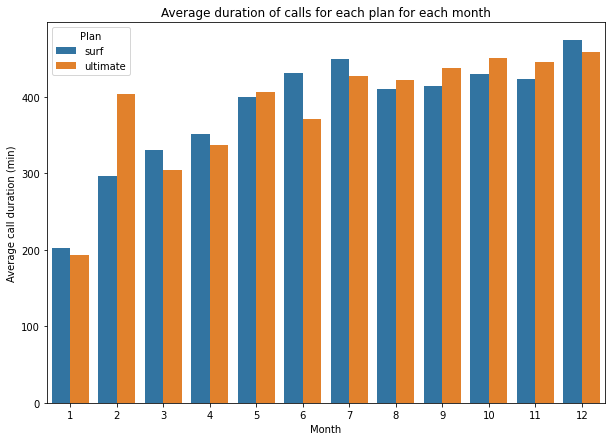

In [63]:
# Comparamos la duración promedio de llamadas por cada plan por cada mes.
df_surf_ultimate = monthly_use[monthly_use['plan_name'].isin(['surf', 'ultimate'])]
df_avg_duration = df_surf_ultimate.groupby(['month', 'plan_name'])['total_duration'].mean().reset_index()

plt.figure(figsize=(10, 7))
sns.barplot(x='month', y='total_duration', hue='plan_name', data=df_avg_duration)
plt.xlabel('Month')
plt.ylabel('Average call duration (min)')
plt.title('Average duration of calls for each plan for each month')
plt.legend(title='Plan')
plt.show()

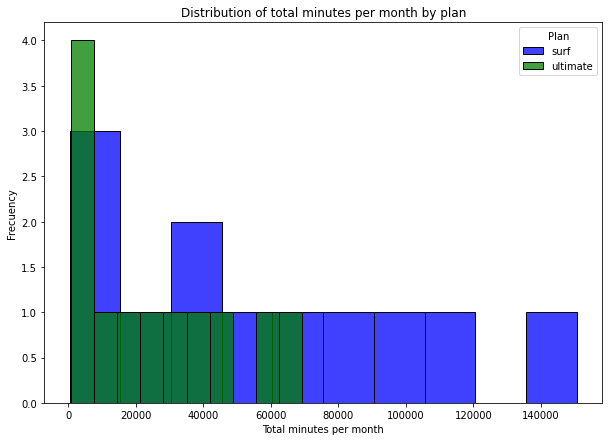

In [64]:
# Comparamos el número de minutos que los usuarios de cada plan requieren cada mes.
surf_df = monthly_use[monthly_use['plan_name'] == 'surf'].groupby('month')['total_duration'].sum()
ulrimate_df = monthly_use[monthly_use['plan_name'] == 'ultimate'].groupby('month')['total_duration'].sum()

colors = ['blue', 'green']

plt.figure(figsize=(10, 7))
sns.histplot(surf_df, bins=10, color=colors[0], label='surf')
sns.histplot(ulrimate_df, bins=10, color=colors[1], label='ultimate')
plt.xlabel('Total minutes per month')
plt.ylabel('Frecuency')
plt.title('Distribution of total minutes per month by plan')
plt.legend(title='Plan')
plt.show()

Calculemos la media y la variable de la duración de la llamada para concluir si los usuarios de diferentes planes muestran comportamientos distintos para sus llamadas.

In [65]:
# Filtremos los datos por plan
df_surf = monthly_use[monthly_use['plan_name'] == 'surf']['total_duration']
df_ultimate = monthly_use[monthly_use['plan_name'] == 'ultimate']['total_duration']

mean_surf = df_surf.mean()
mean_ultimate = df_ultimate.mean()
var_surf = df_surf.var()
var_ultimate = df_ultimate.var()

print('Average duration of calls for the Surf plan:', mean_surf)
print('Average duration of calls for the Ultimate plan:', mean_ultimate)
print('Call duration variance for the Surf plan:', var_surf)
print('Call duration variance for the Ultimate plan:', var_ultimate)

Average duration of calls for the Surf plan: 428.7495232040687
Average duration of calls for the Ultimate plan: 430.45
Call duration variance for the Surf plan: 54968.27946065038
Call duration variance for the Ultimate plan: 57844.46481223922


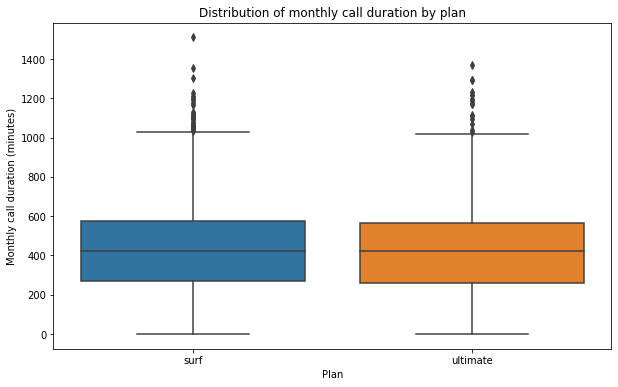

In [66]:
# Tracemos un diagrama de caja para visualizar la distribución de la duración mensual de llamadas.
surf_df = monthly_use[monthly_use['plan_name'] == 'surf']
ultimate_df = monthly_use[monthly_use['plan_name'] == 'ultimate']

plt.figure(figsize=(10, 6))
sns.boxplot(x='plan_name', y='total_duration', data=pd.concat([surf_df, ultimate_df]))
plt.xlabel('Plan')
plt.ylabel('Monthly call duration (minutes)')
plt.title('Distribution of monthly call duration by plan')
plt.show()

Podemos ver que en promedio, los usuarios del plan **'Ultimate'** tienden a realizar llamadas más largas que los usuarios del plan **'Surf'**. Así mismo, la varianza nos indica que las llamdas de los usuarios del plan **'Ultimate'** tienden a realizar llamadas más largas que los del plan **'Surf'**.

### Mensajes

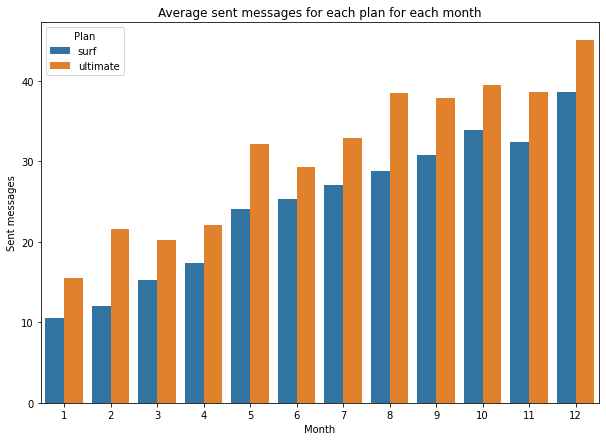

In [67]:
# Comparemos el número de mensajes que tienden a enviar cada mes los usuarios de cada plan
msg_surf_ultimate = monthly_use[monthly_use['plan_name'].isin(['surf', 'ultimate'])]
df_avg_messages = msg_surf_ultimate.groupby(['month', 'plan_name'])['total_messages'].mean().reset_index()

plt.figure(figsize=(10, 7))
sns.barplot(x='month', y='total_messages', hue='plan_name', data=df_avg_messages)
plt.xlabel('Month')
plt.ylabel('Sent messages')
plt.title('Average sent messages for each plan for each month')
plt.legend(title='Plan')
plt.show()

In [68]:
df_surf = monthly_use[monthly_use['plan_name'] == 'surf']['total_messages']
df_ultimate = monthly_use[monthly_use['plan_name'] == 'ultimate']['total_messages']

mean_surf_messages = df_surf.mean()
mean_ultimate_messages = df_ultimate.mean()
var_surf_messages = df_surf.var()
var_ultimate_messages = df_ultimate.var()

print('Average number of messages per month for the Surf plan:', mean_surf_messages)
print('Average number of messages per month for the Ultimate plan:', mean_ultimate_messages)
print('Variation of total messages for the Surf plan:', var_surf_messages)
print('Variation of total messages for the Ultimate plan:', var_ultimate_messages)

Average number of messages per month for the Surf plan: 31.15956770502225
Average number of messages per month for the Ultimate plan: 37.55138888888889
Variation of total messages for the Surf plan: 1126.7245219504066
Variation of total messages for the Ultimate plan: 1208.756743548138


Podemos ver que para el plan Ultimate, la cantidad promedio de mensajes es mayor en comparación con el plan Surf.

En general, la cantidad promedio de mensajes utilizados por los usuarios en ambos planes tiende a variar a lo largo del año. Esto puede ser causa de días festivos por ejemplo.

### Internet

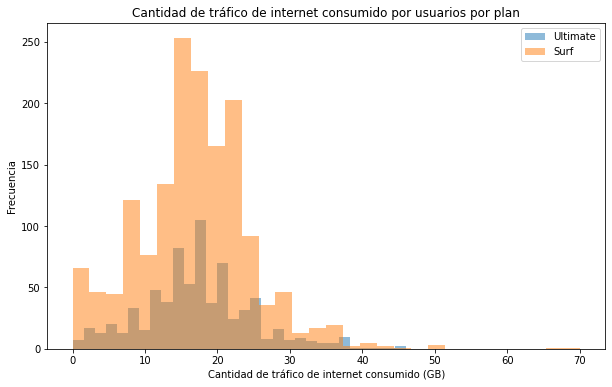

In [69]:
# Compara la cantidad de tráfico de internet consumido por usuarios por plan
plt.figure(figsize=(10, 6))
plt.hist(monthly_use[monthly_use['plan_name'] == 'ultimate']['gb_used'], bins=30, alpha=0.5, label='Ultimate')
plt.hist(monthly_use[monthly_use['plan_name'] == 'surf']['gb_used'], bins=30, alpha=0.5, label='Surf')
plt.xlabel('Cantidad de tráfico de internet consumido (GB)')
plt.ylabel('Frecuencia')
plt.legend()
plt.title('Cantidad de tráfico de internet consumido por usuarios por plan')
plt.show()

Podemos ver que los usuarios del plan surf utilizan un mayor volumen de tráfico de internet en comparación con los usuarios del plan ultimate. También su uso varía a lo largo del año, como pasa con las llamadas.

## Ingreso

Del mismo modo en que has estudiado el comportamiento del usuario, es decir, estadísticamente, describamos el ingreso entre los planes.

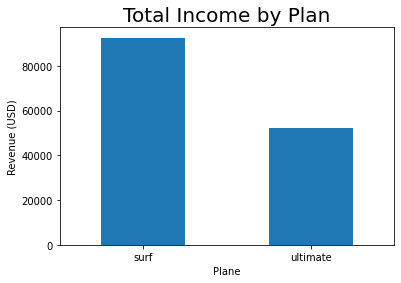

In [70]:
surf_ultimate = monthly_use[monthly_use['plan_name'].isin(['surf', 'ultimate'])]

total_income_by_plan = surf_ultimate.groupby('plan_name')['total_income'].sum()

total_income_by_plan.plot(kind='bar', rot=0)
plt.title('Total Income by Plan', fontsize=20)
plt.xlabel('Plane')
plt.ylabel('Revenue (USD)')
plt.show()

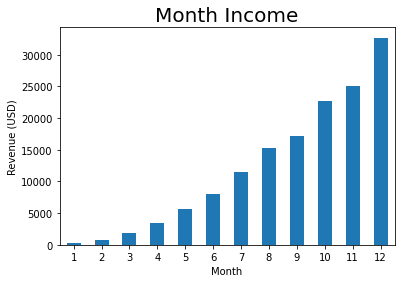

In [71]:
surf_ultimate = monthly_use[monthly_use['plan_name'].isin(['surf', 'ultimate'])]

total_income_by_plan = surf_ultimate.groupby('month')['total_income'].sum()

total_income_by_plan.plot(kind='bar', rot=0)
plt.title('Month Income', fontsize=20)
plt.xlabel('Month')
plt.ylabel('Revenue (USD)')
plt.show()

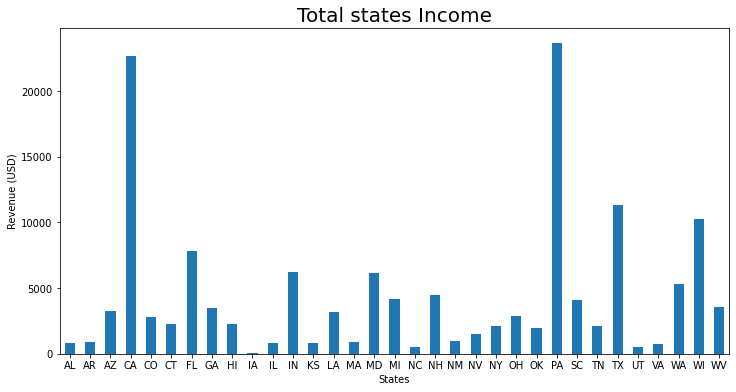

In [72]:
plt.figure(figsize=(12, 6))

surf_ultimate = monthly_use[monthly_use['plan_name'].isin(['surf', 'ultimate'])]

total_income_by_plan = surf_ultimate.groupby('state')['total_income'].sum()

total_income_by_plan.plot(kind='bar', rot=0)
plt.title('Total states Income', fontsize=20)
plt.xlabel('States')
plt.ylabel('Revenue (USD)')
plt.show()

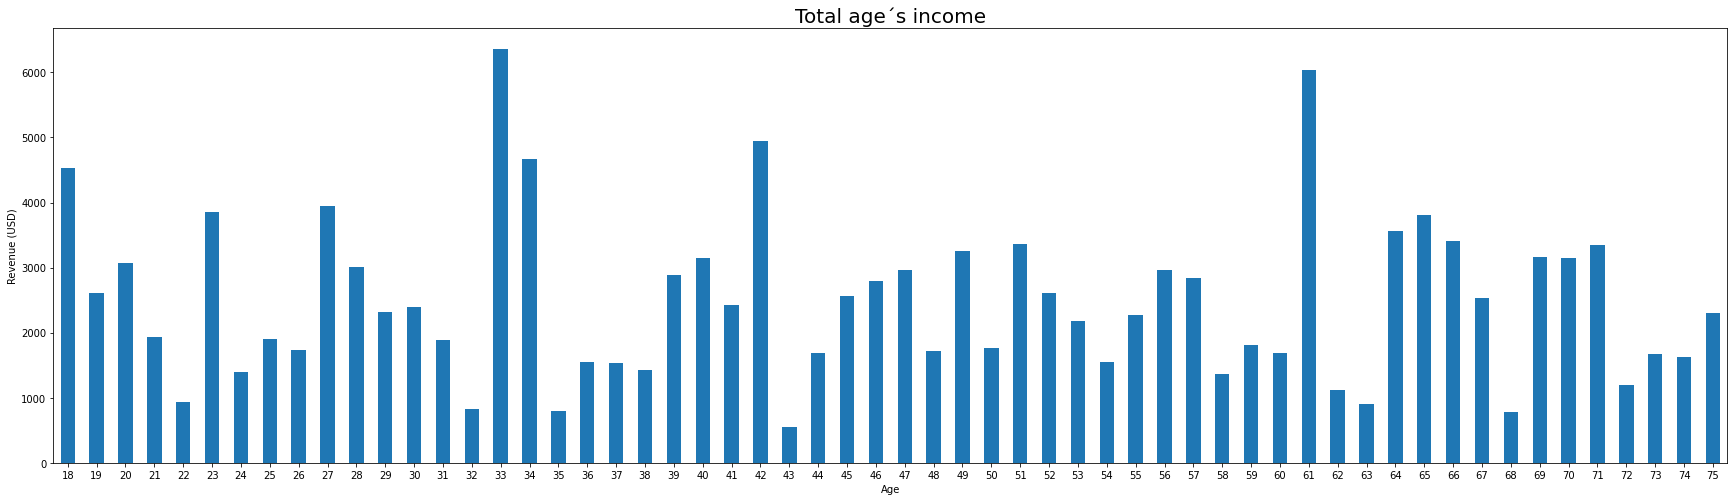

In [73]:
plt.figure(figsize=(30, 8))

surf_ultimate = monthly_use[monthly_use['plan_name'].isin(['surf', 'ultimate'])]

total_income_by_plan = surf_ultimate.groupby('age')['total_income'].sum()

total_income_by_plan.plot(kind='bar', rot=0)
plt.title('Total age´s income', fontsize=20)
plt.xlabel('Age')
plt.ylabel('Revenue (USD)')
plt.show()

Podemos observar que los ingresos totales obtenidos de los usuarios del plan surf son más altos en comparación con los ingresos obtenidos de los usuarios del plan ultimate. Aquí podemos comprobar que el volumen de usuarios en cada plan afecta directamente al ingreso total, aun teniendo en cuenta que el plan ultimate es más caro.

## Probar las hipótesis estadísticas.

Probemos las hipótesis de que es diferente el ingreso promedio de los usuarios de los planes de llamada Ultimate y Surf.

1. H0: El ingreso promedio de los usuarios de los planes **Surf** y **Ultimate** es igual.
2. H1: El ingreso promedio de los usuarios de los planes **Surf** y **Ultimate** es diferente.

Prueba estadística: t-test independiente

Valor alfa: 0.05

In [74]:
# Probemos las hipótesis

# Filtramos el dataframe por planes
df_filtered = monthly_use[monthly_use['plan_name'].isin(['surf', 'ultimate'])]

# Separamos los ingresos por plan en dos grupos
income_surf = df_filtered[df_filtered['plan_name'] == 'surf']['total_income']
income_ultimate = df_filtered[df_filtered['plan_name'] == 'ultimate']['total_income']

# Realizamos la prueba de hipótesis usando t-test independiente
t_stat, p_value = st.ttest_ind(income_surf, income_ultimate, equal_var=False)


print("Estadística de prueba (t-stat):", t_stat)
print("Valor p:", p_value)

# Comparamos el valor p con el valor alfa
alpha = 0.05
if p_value < alpha:
    print("Se rechaza la hipótesis nula")
else:
    print("No se puede rechazar la hipótesis nula")

Estadística de prueba (t-stat): -9.344718611813233
Valor p: 2.5613755181532966e-20
Se rechaza la hipótesis nula


Con esto comprobamos que hay evidencia estadística para sugerir que **hay una diferencia significativa en el ingreso promedio entre Surf y Ultimate.**

## Hipótesis 2

Probemos la hipótesis de que el ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones.

1. H0: El ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones.
2. H1: El ingreso promedio de los usuarios del área NY-NJ es igual al de los usuarios de otras regiones.

Prueba estadística: t de dos muestras

Valor alfa: 0.05

In [75]:
# Probemos las hipótesis

df_ny_nj = monthly_use[monthly_use['state'].isin(['NY', 'NJ'])]
df_other_regions = monthly_use[~monthly_use['state'].isin(['NY', 'NJ'])]

# Realizar la prueba t de dos muestras
t_stat, p_value = st.ttest_ind(df_ny_nj['total_income'], df_other_regions['total_income'], equal_var=False)

# Imprimir los resultados
print("Estadística de prueba (t-stat):", t_stat)
print("Valor p:", p_value)

# Comparar el valor p con el valor alfa para tomar una decisión sobre la hipótesis nula y alternativa
alpha = 0.05
if p_value < alpha:
    print("Se rechaza la hipótesis nula")
else:
    print("No se rechaza la hipótesis nula")

Estadística de prueba (t-stat): 0.9604197368729939
Valor p: 0.34493044628144276
No se rechaza la hipótesis nula


Con el resultado del valor p siendo mayor que alfa, podemos concluir que **no se encontró una diferencia significativa en el ingreso promedio entre los usuarios del área NY-NJ y los usuarios de otras regiones.**

## Conclusión general

Para empezar, corregimos los datos de los distintos dataframes para facilitar su uso, al tener los datos de los distintos dataframes con los mismos tipos de valores, pudimos empezar a agregar columnas con sus calculos requeridos para poder empezar el análisis del proyecto, teniendo en cuenta las restricciones que tenía cada plan. 

Después, calculamos el comportamiento de los usuarios por mes y por plan, esto nos ayudo a tener idea sobre los clientes en general y su comportamiento, asi como su afectación a los ingresos que recibe la compañia mes con mes. 

Para poder visualizar mejor los datos obtenidos hasta ese punto, utilizamos gráficos sobre el comportamiento de los usuarios en terminos de llamadas, mensajes y el tráfico de internet por cada mes durante todo el 2018. 

- Para concluir, pudimos ver que en promedio, los usuarios del plan 'Ultimate' tienden a realizar llamadas más largas que los usuarios del plan 'Surf'. Así mismo, la varianza nos indica que las llamdas de los usuarios del plan 'Ultimate' tienden a realizar llamadas más largas que los del plan 'Surf'.

- Para el plan surf, la cantidad promedio de mensajes es mayor en comparación con el plan ultimate.

- En general, la cantidad promedio de mensajes utilizados por los usuarios en ambos planes tiende a variar a lo largo del año. Esyo puede ser causa de días festivos por ejemplo. Tengamos en cuenta que los usuarios no pertenecen al mismo estado.

- Los usuarios del plan surf utilizan un mayor volumen de tráfico de internet en comparación con los usuarios del plan ultimate. También su uso varía a lo largo del año, como pasa con las llamadas.

- En terminos de ingresos, los ingresos totales obtenidos de los usuarios del plan surf son más altos en comparación con los ingresos obtenidos de los usuarios del plan ultimate. Aquí podemos comprobar que el volumen de usuarios en cada plan afecta directamente al ingreso total, aun teniendo en cuenta que el plan ultimate es más caro.